In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import math
from gym import Env, spaces
import time
font = cv2.FONT_HERSHEY_COMPLEX_SMALL 

In [2]:
model_path = r"/Users/nangyunethitsar/Desktop/FYP/static-7_4_2022.h5"

In [3]:
#!pip install gym

In [4]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)
    
    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y
        
        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)

In [5]:
class Robot(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Robot, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("robot.PNG") / 255.0
        self.icon_w = 20
        self.icon_h = 20
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [6]:
class Obstical(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Obstical, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("building.png") / 255.0
        self.icon_w = 20
        self.icon_h = 20
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
        

In [7]:
class Flag(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Flag, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("flag.PNG") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

In [8]:
class Robot_Env(Env):
    def __init__(self):
        super(Robot_Env, self).__init__()
        
        # Define a 2-D observation space
        self.observation_shape = (400, 400, 3)
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6,)
        
         # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        self.elements = []
        self.max_fuel = 300
        
        
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]
       
    
    
    def step(self, action):
        done = False
        assert self.action_space.contains(action), "Invalid Action"
        # Decrease the fuel counter 
        self.fuel_left -= 1 
        # Reward for executing a step.
       
        
        
        if action == 0:
            self.robot.move(0,5)
        elif action == 1:
            self.robot.move(0,-5)
        elif action == 2:
            self.robot.move(5,0)
        elif action == 3:
            self.robot.move(-5,0)
        elif action == 4:
            self.robot.move(0,0)
            
        
        
        
        
        reward = 0 
        
        for elem in self.elements:
            ## check robot hit building
            if isinstance(elem, Obstical):
                if self.has_collided(self.robot, elem):
                    # Conclude the episode and remove the chopper from the Env.
                    done = True
                    reward = -10
                    #self.elements.remove(self.robot)

            elif isinstance(elem, Flag):
                if self.has_collided(self.robot, elem):
                    done = True
                    reward = 100
                    self.elements.remove(self.robot)

                else:
                    robot_x, robot_y = self.robot.get_position()
                    goal_x,goal_y = elem.get_position()
                    dist =  math.sqrt((goal_x -robot_x)**2+(goal_y-robot_y)**2)
                    reward = (1/dist) * 1000
                        
                        

                
    
         # Increment the episodic return
        self.ep_return += reward
        
        # Draw elements on the canvas
        self.draw_elements_on_canvas()
        
        # If out of fuel, end the episode.
        if self.fuel_left == 0:
            done = True

        return self.canvas, reward, done, []
            
    
    
        
    def reset(self):
        # Reset the fuel consumed
        self.fuel_left = self.max_fuel

        # Reset the reward
        self.ep_return  = 0
        
        
        # Number of building
        self.obstical_count = 0
        
        
        x = random.randrange(int(self.observation_shape[0] * 0.05), int(self.observation_shape[0] * 0.10))
        y = random.randrange(int(self.observation_shape[1] * 0.15), int(self.observation_shape[1] * 0.20))
        
        self.robot = Robot("Robot", self.x_max, self.x_min, self.y_max, self.y_min)
        self.robot.set_position(x,y)
        
        
         # Intialise the elements 
        self.elements = [self.robot]
        
        
        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw elements on the canvas
        self.draw_elements_on_canvas()


        # return the observation
        return self.canvas 
    
    
    
    def set_obsticals(self,points):
        for obstical_x, obstical_y in points:
            obstical_obj  =  Obstical("obstical_{}".format(self.obstical_count), self.x_max, self.x_min, self.y_max, self.y_min) 
            obstical_obj.set_position(obstical_x, obstical_y)
            self.elements.append(obstical_obj)
            self.draw_elements_on_canvas()
        return self.canvas

    def set_goal(self,points):
        for flag_x, flag_y in  points:
            flag_obj = Flag("flag_{}".format(self.obstical_count), self.x_max, self.x_min, self.y_max, self.y_min) 
            flag_obj.set_position(flag_x, flag_y)
            self.elements.append(flag_obj)
            self.draw_elements_on_canvas()
        return self.canvas
    
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the heliopter on canvas
        for elem in self.elements:
            elem_shape = elem.icon.shape
            x,y = elem.x, elem.y
            self.canvas[y : y + elem_shape[1], x:x + elem_shape[0]] = elem.icon

        text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

        # Put the info on canvas 
        self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
                   0.8, (0,0,0), 1, cv2.LINE_AA)
    
    
    def get_action_meanings(self):
        return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            cv2.imshow("Obstacle Avoidance Robot", self.canvas)
            cv2.waitKey(10)

        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()
        
    def has_collided(self, elem1, elem2):
        x_col = False
        y_col = False

        elem1_x, elem1_y = elem1.get_position()
        elem2_x, elem2_y = elem2.get_position()

        if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
            x_col =  True

        if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
            y_col = True

        if x_col and y_col:
            return True

        return False

/opt/anaconda3/envs/rltrain/lib/python3.8/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float16
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


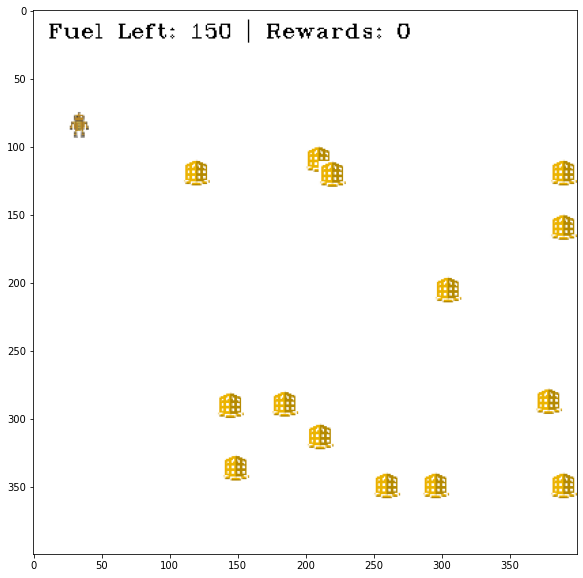

In [9]:
full_obstacle_list = [ (200,100), (400,150),(400, 110), 
                 (430, 390), (201, 304), (135, 281), 
                 (286, 373), (175, 280), (250, 375), (139, 327), (369, 278), 
                 (295, 196), (210, 111),(110,110)]

env = Robot_Env()
obs = env.reset()
obstical_env = env.set_obsticals(full_obstacle_list)
plt.figure(figsize=(10, 10))
plt.imshow(obstical_env)

In [10]:
from IPython import display

env = Robot_Env()
obs = env.reset()

goal_pos = [[380,380]]
full_obstacle_list = [ (200,100), (400,150),(400, 110), 
                 (430, 390), (201, 304), (135, 281), 
                 (286, 373), (175, 280), (250, 375), (139, 327), (369, 278), 
                 (295, 196), (210, 111),(110,110)]


env.set_obsticals(full_obstacle_list)
env.set_goal(goal_pos)


while True:
    # Take a random action
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    
    # Render the game
    env.render()
    
    if done == True:
        break

env.close()

## Load tf model

In [11]:
import tensorflow as tf

/opt/anaconda3/envs/rltrain/lib/python3.8/site-packages/flatbuffers/compat.py:19: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/opt/anaconda3/envs/rltrain/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:23: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  'nearest': pil_image.NEAREST,
/opt/anaconda3/envs/rltrain/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:24: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  'bilinear': pil_image.BILINEAR,
/opt/anaconda3/envs/rltrain/lib/python3.8/site-packages/keras_preprocessing/image/utils.py:25: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  'bicubic': pil_image.BICUBIC,
/opt/anaconda3/en

In [12]:
def load_my_model(model_path):
    model = tf.keras.models.load_model(model_path)
    return model

In [13]:
model =  load_my_model(model_path)
model.summary()

2022-04-14 11:30:48.983321: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 63, 63, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 63, 63, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                            

### Helper functions

In [14]:
n_actions = 5
from IPython import display as ipythondisplay

In [15]:
def pre_process(image_frame):
    
   
    I = image_frame[20:] # Crop
    
    #print("Croped Image size : ",I.shape)
    I = cv2.resize(I,(128,128))
    return I.astype(np.float32)

In [16]:
def isNan(val):
     return val != val

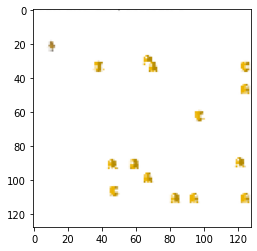

In [17]:
test_img = pre_process(obstical_env)
plt.imshow(test_img)
plt.show()

### rl logic

In [18]:
def choose_action(model,observation):
    
    observation = np.expand_dims(observation,axis = 0)
    
    logits = model.predict(observation)
    
    prob_weights = tf.nn.softmax(logits).numpy()
    
    isContainNan =  [ isNan(x) for x in prob_weights.flatten()]
    
    if True in   isContainNan:
        return np.random.choice(n_actions,size = 1)[0]
    
    action = np.random.choice(n_actions,size = 1, p = prob_weights.flatten())[0]
    
    return action


In [19]:
class Memory:
    def __init__(self):
        self.clear()
        
    
    def clear(self):
        self.observations = []
        self.actions = []
        self.rewards = []
        
    def add_to_memory(self,new_observation,new_action,new_reward):
        self.observations.append(new_observation)
        
        self.actions.append(new_action)
        
        self.rewards.append(new_reward)

In [20]:

test_action = choose_action(model,test_img)
print("Predicted output : ",test_action)

Predicted output :  2


In [21]:
### test model is predict or not

MAX_ITERS = 30
memory = Memory()

In [22]:
for i_episode in range(MAX_ITERS):
    
    
    # Restart the environment
    observation = env.reset()
    env.set_obsticals(full_obstacle_list)
    env.set_goal(goal_pos)

    previous_frame = pre_process(observation)
    
    while True :
        current_frame =  pre_process(observation)
        
        obs_change = current_frame - previous_frame
        plt.imshow(obs_change)
        action = choose_action(model,obs_change)
        env.render()
        next_observation, reward, done, info = env.step(action)
        
        memory.add_to_memory(obs_change,action,reward)
        
        if done :
            total_reward = sum(memory.rewards)
            memory.clear()
            
            print("Total Reward : ",total_reward)
            break
        
        observation = next_observation
        previous_frame = current_frame

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  131.12750241769425


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  439.24189973560067


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  100.4400902280577


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  202.9730993586605


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  499.983261153869


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  169.17735548818203


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  479.7979526471721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  153.95363213205906


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  510.59660712928843


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  518.6314443620689


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  119.51267230859297


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  129.10378075621094


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Total Reward :  154.82745430298317


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i